In [41]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [55]:
normalized_titers = pd.read_csv('./denv3_smith_agm1mo_huMono_normalized.tsv', sep='\t', header=None, 
                                names=['test_virus', 'serum', 'serum_id', 'val'],
                               dtype={'test_virus': str, 'serum': str, 'serum_id': str, 'val':float})
# { (test_virus, serum): average normalized titer value }
normalized_titers = normalized_titers.groupby(['test_virus', 'serum']).val.aggregate(np.average).to_dict()
# pprint(normalized_titers)

divergence = pd.read_csv('./denv3_patristic.csv', header=0, index_col=0)
divergence.fillna(0, inplace=True)

In [59]:
x = []
y = []
for (virus, serum), value in normalized_titers.items():
    y.append(value)
    x.append(divergence.at[virus, serum])
assert len(x) == len(y)

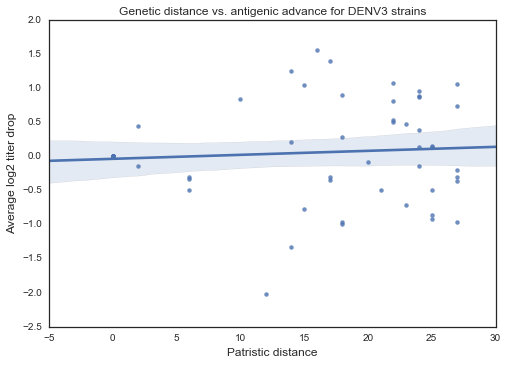

In [61]:
fig, ax = plt.subplots()
sns.regplot(pd.Series(x), pd.Series(y))

ax.set_xlabel('Patristic distance', size=12)
ax.set_ylabel('Average log2 titer drop', size=12)
ax.set_title('Genetic distance vs. antigenic advance for DENV3 strains', size=12)